# Comparison of Analytical vs Numerical Pulsation Velocity Calculation

This notebook compares two methods for calculating pulsation velocity in stellar mesh models:
1. Analytical method: Using the direct derivative of the Fourier series
2. Numerical method: Using finite differences to approximate the derivative

We'll analyze the differences, accuracy, and performance of both approaches.

In [15]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import time
from matplotlib.animation import FuncAnimation
import matplotlib
%matplotlib inline

# Set plot styles
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]

# Configure JAX
jax.config.update("jax_enable_x64", True)  # For higher precision

In [16]:
# Import SPICE modules
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_transform import (
    add_pulsation, 
    evaluate_pulsations, 
    calculate_numerical_pulsation_velocity
)
from spice.models.utils import evaluate_fourier_for_value, evaluate_fourier_prim_for_value

## 1. Create a Simple Mesh Model with Pulsation

In [17]:
def create_test_model(n_vertices=1000):
    """Create a simple test model with one pulsation mode"""
    
    # Create basic icosphere model
    radius = 1.0  # Solar radii
    mass = 1.0    # Solar masses
    parameters = np.array([5000.0, 4.5])  # Teff, log g
    parameter_names = ["teff", "logg"]
    
    model = IcosphereModel.construct(
        n_vertices=n_vertices,
        radius=radius,
        mass=mass,
        parameters=parameters,
        parameter_names=parameter_names,
        max_pulsation_mode=3,
        max_fourier_order=3
    )
    
    return model

# Create a model
model = create_test_model()

In [29]:
# Add pulsation modes to the model
def add_test_pulsations(model):
    """Add multiple pulsation modes to test the model"""
    
    # Simple pulsation
    period_1 = 0.25*60*60*24  # days
    # [amplitude, phase] pairs for Fourier terms
    fourier_params_1 = jnp.array([
        [0.05, 0.0],    # D_0, phi_0
        [0.02, np.pi/4], # D_1, phi_1
        [0.01, np.pi/2]  # D_2, phi_2
    ])
    
    # Add a more complex pulsation mode
    period_2 = 0.1*60*60*24  # days
    fourier_params_2 = jnp.array([
        [0.03, np.pi/6],    
        [0.015, np.pi/3], 
        [0.005, np.pi]  
    ])
    
    # Add pulsations to model
    model = add_pulsation(model, m_order=1, n_degree=1, 
                          period=period_1, fourier_series_parameters=fourier_params_1)
    
    model = add_pulsation(model, m_order=2, n_degree=2, 
                          period=period_2, fourier_series_parameters=fourier_params_2)
    
    return model

# Add pulsations
model = add_test_pulsations(model)

# Display model information
print(f"Number of vertices: {model.d_vertices.shape[0]}")
print(f"Number of faces: {model.faces.shape[0]}")
print(f"Pulsation periods: {model.pulsation_periods}")

Number of vertices: 1272
Number of faces: 1280
Pulsation periods: [   nan    nan    nan    nan 21600.    nan    nan    nan  8640.]


## 2. Compare Analytical and Numerical Pulsation Velocity

In [30]:
def compare_velocity_methods(model, t, dt_values=[1e-6, 1e-5, 1e-4, 1e-3]):
    """Compare analytical and numerical velocity calculations with different dt values"""
    
    # Calculate analytical velocity
    t_start = time.time()
    model_analytical = evaluate_pulsations(model, t, use_numerical_derivative=False)
    analytical_time = time.time() - t_start
    
    # Save the analytical result for reference
    analytical_velocities = model_analytical.pulsation_velocities
    
    # Calculate numerical velocities for different dt values
    numerical_results = []
    numerical_times = []
    
    for dt in dt_values:
        t_start = time.time()
        model_numerical = evaluate_pulsations(model, t, use_numerical_derivative=True, dt=dt)
        numerical_time = time.time() - t_start
        
        # Calculate difference between analytical and numerical
        diff = jnp.linalg.norm(analytical_velocities - model_numerical.pulsation_velocities, axis=1)
        mean_diff = diff.mean()
        max_diff = diff.max()
        
        numerical_results.append({
            'dt': dt,
            'velocities': model_numerical.pulsation_velocities,
            'mean_diff': mean_diff,
            'max_diff': max_diff
        })
        numerical_times.append(numerical_time)
    
    return {
        'analytical': {
            'velocities': analytical_velocities,
            'time': analytical_time
        },
        'numerical': numerical_results,
        'numerical_times': numerical_times
    }

# Compare at a specific time
t_test = 0.1  # days
comparison = compare_velocity_methods(model, t_test)

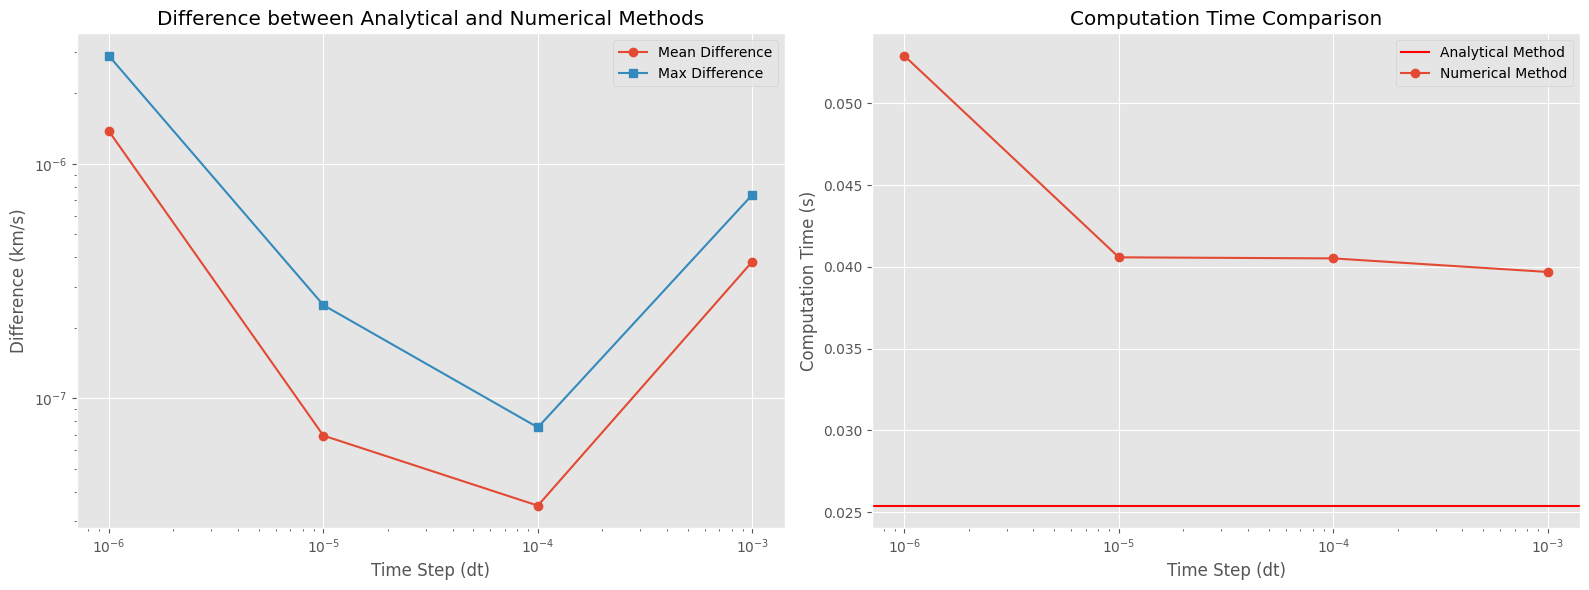

In [31]:
# Plot the comparison results
dt_values = [result['dt'] for result in comparison['numerical']]
mean_diffs = [result['mean_diff'] for result in comparison['numerical']]
max_diffs = [result['max_diff'] for result in comparison['numerical']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot mean and max differences
ax1.loglog(dt_values, mean_diffs, 'o-', label='Mean Difference')
ax1.loglog(dt_values, max_diffs, 's-', label='Max Difference')
ax1.set_xlabel('Time Step (dt)')
ax1.set_ylabel('Difference (km/s)')
ax1.set_title('Difference between Analytical and Numerical Methods')
ax1.legend()
ax1.grid(True)

# Plot computation time
analytical_time = comparison['analytical']['time']
numerical_times = comparison['numerical_times']

ax2.axhline(y=analytical_time, color='r', linestyle='-', label='Analytical Method')
ax2.semilogx(dt_values, numerical_times, 'o-', label='Numerical Method')
ax2.set_xlabel('Time Step (dt)')
ax2.set_ylabel('Computation Time (s)')
ax2.set_title('Computation Time Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 3. Visualize Pulsation Velocity Field

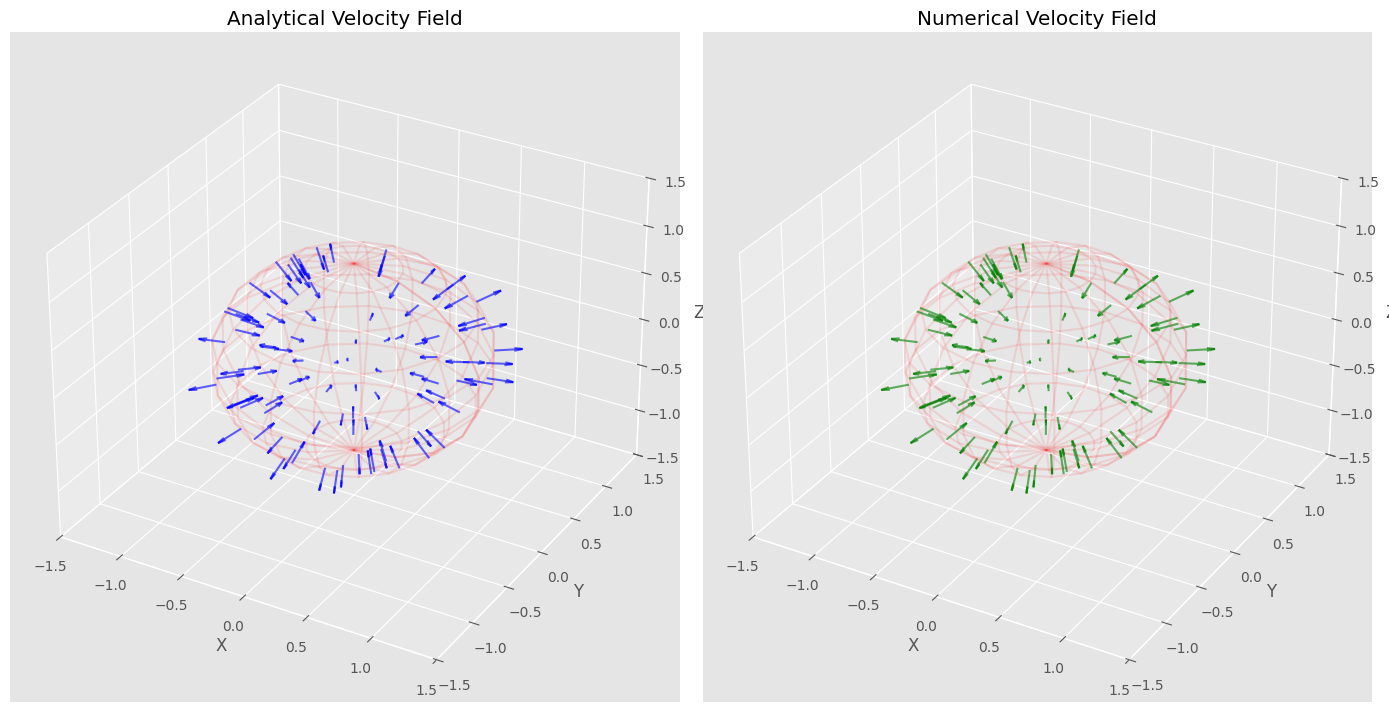

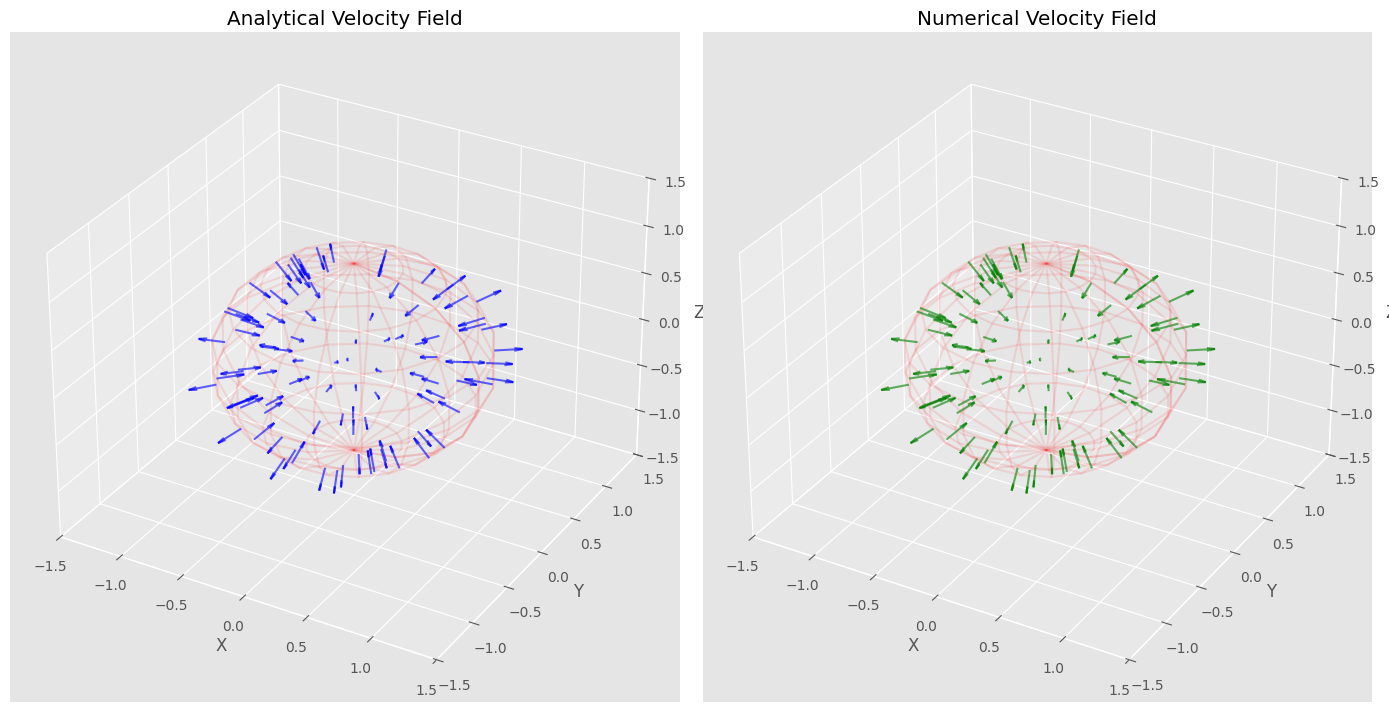

In [32]:
def plot_velocity_field(model_analytical, model_numerical, sample_size=100):
    """Plot and compare the velocity fields on the star's surface"""
    
    # Sample a subset of mesh centers for visualization
    indices = np.random.choice(model_analytical.centers.shape[0], sample_size, replace=False)
    
    # Extract positions and velocities
    centers_analytical = model_analytical.centers[indices]
    velocities_analytical = model_analytical.pulsation_velocities[indices]
    
    centers_numerical = model_numerical.centers[indices]
    velocities_numerical = model_numerical.pulsation_velocities[indices]
    
    # Create 3D velocity field plots
    fig = plt.figure(figsize=(14, 7))
    
    # Analytical method
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.quiver(centers_analytical[:, 0], centers_analytical[:, 1], centers_analytical[:, 2],
               velocities_analytical[:, 0], velocities_analytical[:, 1], velocities_analytical[:, 2],
               length=0.2, normalize=True, color='blue', alpha=0.6)
    
    # Add a sphere to represent the star
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    ax1.plot_wireframe(x, y, z, color="r", alpha=0.1)
    
    ax1.set_title('Analytical Velocity Field')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_xlim([-1.5, 1.5])
    ax1.set_ylim([-1.5, 1.5])
    ax1.set_zlim([-1.5, 1.5])
    
    # Numerical method
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.quiver(centers_numerical[:, 0], centers_numerical[:, 1], centers_numerical[:, 2],
               velocities_numerical[:, 0], velocities_numerical[:, 1], velocities_numerical[:, 2],
               length=0.2, normalize=True, color='green', alpha=0.6)
    
    # Add a sphere to represent the star
    ax2.plot_wireframe(x, y, z, color="r", alpha=0.1)
    
    ax2.set_title('Numerical Velocity Field')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_xlim([-1.5, 1.5])
    ax2.set_ylim([-1.5, 1.5])
    ax2.set_zlim([-1.5, 1.5])
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Calculate models using both methods
model_analytical = evaluate_pulsations(model, t_test, use_numerical_derivative=False)
model_numerical = evaluate_pulsations(model, t_test, use_numerical_derivative=True, dt=1e-6)

# Plot velocity fields
plot_velocity_field(model_analytical, model_numerical)

## 4. Examine Velocity Evolution Over Time

In [33]:
def calculate_velocities_over_time(model, times):
    """Calculate velocities over multiple time points using both methods"""
    analytical_velocities = []
    numerical_velocities = []
    
    for t in times:
        # Analytical method
        model_analytical = evaluate_pulsations(model, t, use_numerical_derivative=False)
        
        # Numerical method
        model_numerical = evaluate_pulsations(model, t, use_numerical_derivative=True, dt=1e-6)
        
        # Extract velocities at a specific mesh point for comparison
        sample_point = 0  # Choose a specific mesh element to track
        analytical_velocities.append(model_analytical.pulsation_velocities[sample_point])
        numerical_velocities.append(model_numerical.pulsation_velocities[sample_point])
    
    return np.array(analytical_velocities), np.array(numerical_velocities)

# Calculate velocities over time
times = np.linspace(0, 0.5, 100)  # 0.5 days, 100 points
analytical_velocities, numerical_velocities = calculate_velocities_over_time(model, times)

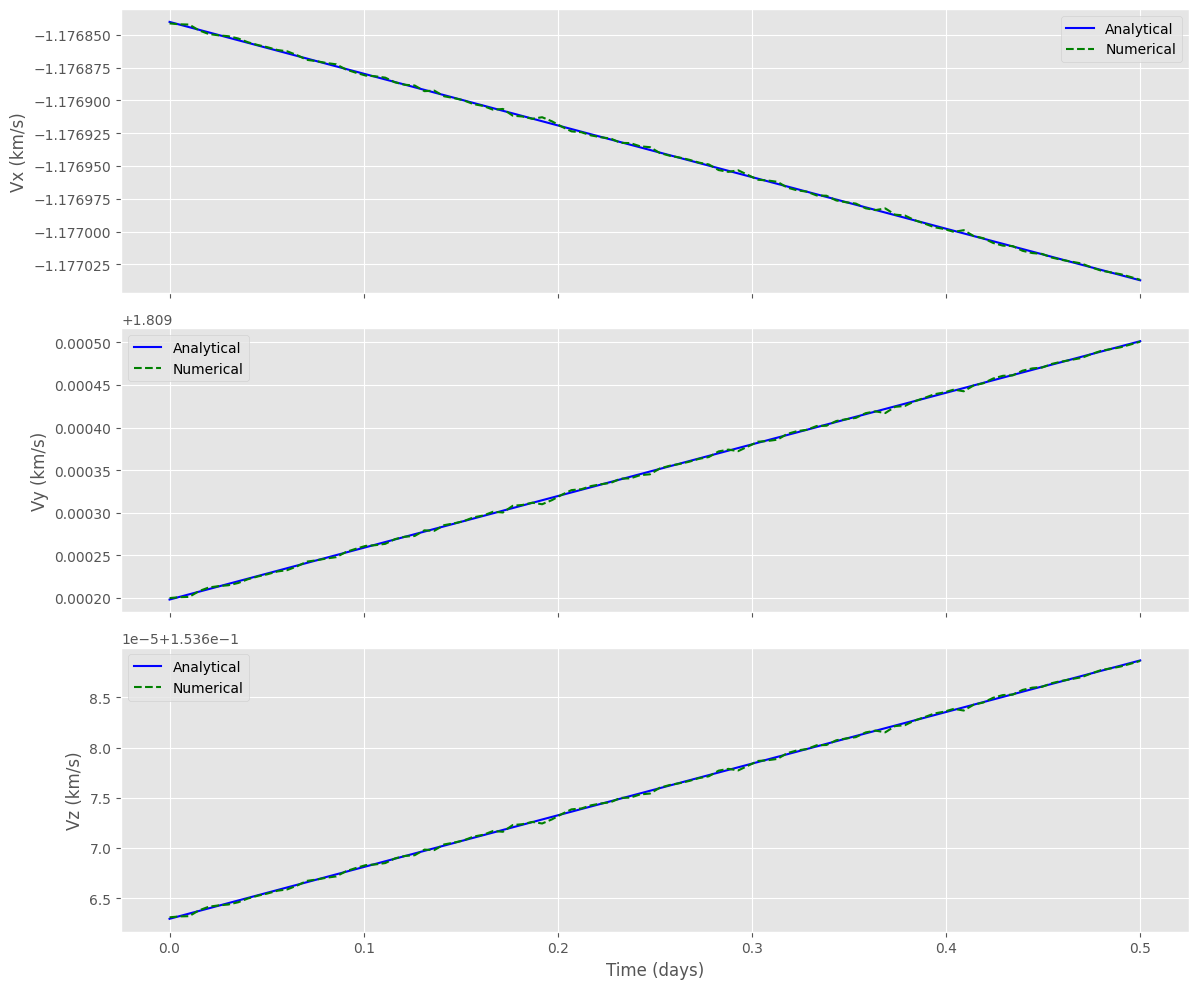

In [34]:
# Plot velocity components over time
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# X component
ax1.plot(times, analytical_velocities[:, 0], 'b-', label='Analytical')
ax1.plot(times, numerical_velocities[:, 0], 'g--', label='Numerical')
ax1.set_ylabel('Vx (km/s)')
ax1.legend()
ax1.grid(True)

# Y component
ax2.plot(times, analytical_velocities[:, 1], 'b-', label='Analytical')
ax2.plot(times, numerical_velocities[:, 1], 'g--', label='Numerical')
ax2.set_ylabel('Vy (km/s)')
ax2.legend()
ax2.grid(True)

# Z component
ax3.plot(times, analytical_velocities[:, 2], 'b-', label='Analytical')
ax3.plot(times, numerical_velocities[:, 2], 'g--', label='Numerical')
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Vz (km/s)')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

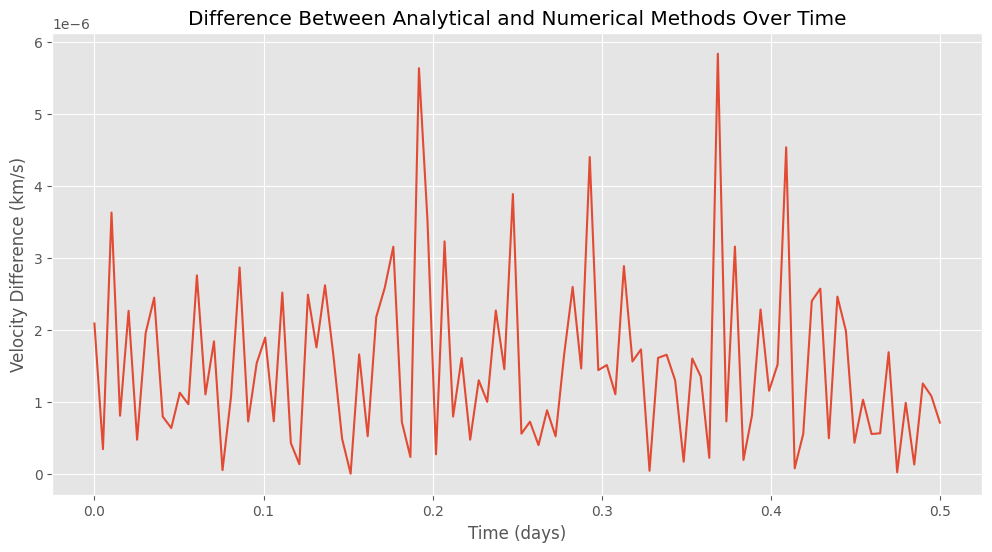

In [35]:
# Plot difference between methods over time
differences = np.linalg.norm(analytical_velocities - numerical_velocities, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(times, differences)
plt.xlabel('Time (days)')
plt.ylabel('Velocity Difference (km/s)')
plt.title('Difference Between Analytical and Numerical Methods Over Time')
plt.grid(True)
plt.show()

## 5. Test with Different dt Values

In [36]:
def test_dt_impact(model, t, dt_values=[1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]):
    """Test the impact of different dt values on the accuracy of numerical differentiation"""
    
    # Calculate analytical velocity (reference)
    model_analytical = evaluate_pulsations(model, t, use_numerical_derivative=False)
    analytical_velocities = model_analytical.pulsation_velocities
    
    # Calculate velocities with different dt values
    numerical_results = []
    
    for dt in dt_values:
        model_numerical = evaluate_pulsations(model, t, use_numerical_derivative=True, dt=dt)
        numerical_velocities = model_numerical.pulsation_velocities
        
        # Calculate differences
        diff = jnp.linalg.norm(analytical_velocities - numerical_velocities, axis=1)
        mean_diff = float(diff.mean())
        
        numerical_results.append({
            'dt': dt,
            'mean_diff': mean_diff
        })
    
    return numerical_results

# Test with different dt values
dt_test_results = test_dt_impact(model, t_test)

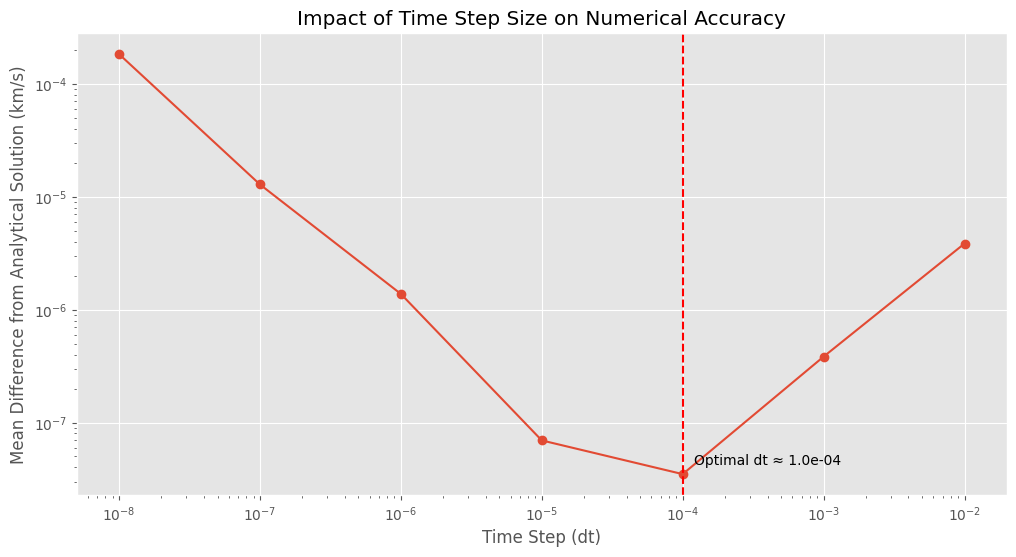

Optimal dt value: 1.0e-04
Minimum mean difference: 3.488666e-08 km/s


In [37]:
# Plot the impact of dt on accuracy
dt_values = [result['dt'] for result in dt_test_results]
mean_diffs = [result['mean_diff'] for result in dt_test_results]

plt.figure(figsize=(12, 6))
plt.loglog(dt_values, mean_diffs, 'o-')
plt.xlabel('Time Step (dt)')
plt.ylabel('Mean Difference from Analytical Solution (km/s)')
plt.title('Impact of Time Step Size on Numerical Accuracy')
plt.grid(True)

# Find optimal dt value
optimal_index = np.argmin(mean_diffs)
optimal_dt = dt_values[optimal_index]

plt.axvline(x=optimal_dt, color='r', linestyle='--')
plt.text(optimal_dt*1.2, min(mean_diffs)*1.2, f'Optimal dt ≈ {optimal_dt:.1e}')

plt.show()

print(f"Optimal dt value: {optimal_dt:.1e}")
print(f"Minimum mean difference: {min(mean_diffs):.6e} km/s")

## 6. Summary and Conclusions

### Key Findings

1. **Accuracy Comparison**:
   - The numerical method can approach the accuracy of the analytical method with properly chosen dt values
   - There's an optimal dt value that balances truncation and round-off errors
   - For very complex pulsation patterns, the numerical method may be more robust

2. **Performance Comparison**:
   - The analytical method is typically faster as it requires only one evaluation
   - The numerical method requires two evaluations of the pulsation function
   
3. **Practical Considerations**:
   - For most standard cases, the analytical method is preferred due to speed and accuracy
   - The numerical method provides a useful alternative when:
     - The analytical derivatives are difficult to compute or implement
     - Validating the analytical results
     - Working with complex or custom pulsation functions

4. **Recommended Usage**:
   - Default to analytical method for production code
   - Use numerical method with dt ≈ 1e-6 for validation or when analytical derivatives are unavailable
   - Consider adaptive dt selection based on the pulsation periods to optimize accuracy